In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%matplotlib notebook

# Imports
import traceback
import numpy as np
import warnings
import matplotlib.pyplot as plt    
import ipywidgets as widgets
import matplotlib.image as mpimg
import numpy.fft as fft
import threading
import time
import types
import scipy.signal
import signal
import sh
import sys
import os
import re
import struct
import visa
import logging
import copy
import glob
import pickle
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.neighbors.kde import KernelDensity
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import itertools
from multiprocessing import Pool

import pprint
pp = pprint.PrettyPrinter(indent=4)


sys.path.append('/home/colindv/sciebo/masterthesis/remote control/Remote control v3 (version control)/')
home = os.environ['HOME']+'/' # home dir

from colors import color_array_solid
from helper_functions import info, debug, warning, error, critical
from ContextManager import ContextManager

mod_schemes_sc =   ["SC_BPSK", "SC_QPSK", "SC_16QAM", "SC_64QAM"]
mod_schemes_ofdm = ["OFDM_BPSK", "OFDM_QPSK", "OFDM_16QAM", "OFDM_64QAM"]
mod_schemes = [*mod_schemes_sc, *mod_schemes_ofdm]
mods = ["BPSK", "QPSK", "16QAM", "64QAM"]
mod_types = ["SC", "OFDM"]

def intersect(it1, it2):
    return [it for it in it1 if it in it2]

def complement(it1, it2):
    return [it for it in it1 if it not in it2]

# load database
with open("/storage/qnap/database.pkl", "rb") as pickle_file:
    data=pickle.load(pickle_file)
df = data['df']
all_features = list(df['X'].columns)
all_features.remove("SNR")

# shuffle and standardize
df = shuffle(df)
scale_features = list(set(all_features) - set(["SNR"]))
df.loc[:,('X', scale_features)] = scale(df.loc[:,('X', scale_features)])

#display(df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
features_max_dependency = ['$\\widetilde{C}_{42}$', '$\\widetilde{C}_{63}$', '$\\sigma_{a}$', '$\\mu^A_{42}$', '$\\nu_{42}$', '$|\\widetilde{C}_{40}|$', '$\\gamma_{4,max}$', '$N_c$ (2nd)', '$\\sigma_{aa}$', '$N_c$ (1st)', '$\\gamma_{2,max}$', '$\\sigma_{af}$', '$C$', 'PAPR', '$\\gamma_{1,max}$', '$|\\widetilde{C}_{61}|$', '$\\mu^f_{42}$', '$\\sigma_{ap,C}$', '$\\sigma_{dp,C}$', '$\\hat{C}_{20}$', '$|\\widetilde{C}_{60}|$', '$|\\widetilde{C}_{62}|$', '$|\\widetilde{C}_{41}|$', '$\\beta$', '$ZC$', '$\\Psi_{max}$', '$\\hat{C}_{21}$', 'SNR', '$\\sigma_{R}$', '$\\sigma_{ap,CNL}$', '$\\sigma_{dp,CNL}$', '$\\mu^R_{42}$']


In [25]:
%matplotlib inline

def get_plotgrid(num_plots, ncols):
    nrows = int(np.ceil(num_plots/ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(13,2+3*nrows), facecolor="white")
    axs = axs.ravel()
    for ax in axs:
        ax.set_visible(False)
    fig.tight_layout()
    return fig, axs
    
def show_kernel_density(ax, dfi, differentiators, legend_features, feature):

    dfi_X = dfi.loc[:,('X', feature)]
    dfi_y = dfi['y']
    differentiators = list(differentiators)

    # drop redundant labels, save redundant legend features for labeling
    nunique = dfi_y.apply(pd.Series.nunique)
    redundant_labels = nunique[nunique == 1].index
    redundant_legend_features = intersect(legend_features, redundant_labels)
    redundant_legend_labels = {feature: (dfi_y.loc[:,feature]).iloc[0] for feature in redundant_legend_features}
    dfi_y = dfi_y.drop(redundant_labels, axis=1)

    # get all combinations of labels
    dfi_unique = dfi_y.drop_duplicates()
    
    # set up axis
    x_min, x_max = np.min(dfi_X.values), np.max(dfi_X.values)
    width = np.abs(x_max-x_min)
    xs = np.linspace(x_min-0.05*width, x_max+0.05*width, 2000)
    ax.set_visible(True)
    ax.set_title(feature)
    colors = iter(color_array_solid)
    
    # depth first search over all combinations of labels
    def dfs(dfi_X, dfi_y, differentiators):
        
        if(len(differentiators) > 0):
            
            label = differentiators.pop(0)
            values = list(set(dfi_y[label]))
            
            # use sorted list if existent for that feature
            for sorted_list in [mods, mod_types]: 
                values = sorted_list if (set(sorted_list) == set(values)) else values
            
            for value in values:
                
                dfi_X_sub = dfi_X.copy()[dfi_y[label] == value]
                dfi_y_sub = dfi_y.copy()[dfi_y[label] == value]
                differentiators_sub = differentiators.copy()
                dfs(dfi_X_sub, dfi_y_sub, differentiators_sub)
                
        else:
            y = dfi_y.drop_duplicates().iloc[0,:] 
            
            # build label from non redundant labels and possibly redundant legend labels
            legend_label = ""
            for feature in legend_features:
                legend_label += y[feature] if feature not in redundant_legend_features else redundant_legend_labels[feature]
                legend_label += " "
            
            # build pdf from marginal distributions dependent of all the remaining labels in dfi_y
            prob_dens = pdf(dfi_X, dfi_y, xs)
            prob_dens[0] = prob_dens[-1] = 0 # for proper plotting 
            
            # plot
            color = next(colors)
            ax.plot(xs, prob_dens, c=color, alpha=0.75)
            ax.fill(xs, prob_dens, fc=color, alpha=0.5, label=legend_label)
            
    dfs(dfi_X, dfi_y, differentiators)

    # set up axis
    ax.zorder=10
    ax.legend(loc=1)
    ax.autoscale(enable=True, axis='both', tight=True)
    ax.set_ylim([0, 1.1*ax.get_ylim()[1]])
    
    return ax
    
def show_features(ax, dfi, differentiators, legend_features, feature):
    
    dfi_X = dfi.loc[:,('X', feature)]
    dfi_y = dfi.loc[:,'y']
    differentiators = list(differentiators)
    
    # drop redundant labels, save redundant legend features for labeling
    nunique = dfi_y.apply(pd.Series.nunique)
    redundant_labels = nunique[nunique == 1].index
    redundant_legend_features = intersect(legend_features, redundant_labels)
    redundant_legend_labels = {feature: (dfi_y.loc[:,feature]).iloc[0] for feature in redundant_legend_features}
    dfi_y = dfi_y.drop(redundant_labels, axis=1)
    
    # get all combinations of labels
    dfi_unique = dfi_y.drop_duplicates()
    
    # set up axis
    ax.set_visible(True)
    ax.set_title(feature)
    ax.autoscale(enable=True, axis='y', tight=True)
    colors = iter(color_array_solid)
    
    # depth first search over all differentiators
    def dfs(dfi_X, dfi_y, differentiators):
        
        if(len(differentiators) > 0):
            
            label = differentiators.pop(0)
            values = list(set(dfi_y[label]))
            
            # use sorted list if existent for that feature
            for sorted_list in [mods, mod_types]: 
                values = sorted_list if (set(sorted_list) == set(values)) else values
            
            for value in values:
                
                dfi_X_sub = dfi_X.copy()[dfi_y[label] == value]
                dfi_y_sub = dfi_y.copy()[dfi_y[label] == value]
                differentiators_sub = differentiators.copy()
                dfs(dfi_X_sub, dfi_y_sub, differentiators_sub)
                
        else:
            xs = np.arange(dfi_X.shape[0])
            y = dfi_y.drop_duplicates().iloc[0,:]
            
            # build label from non redundant labels and possibly redundant legend labels
            legend_label = ""
            for feature in legend_features:
                legend_label += y[feature] if feature not in redundant_legend_features else redundant_legend_labels[feature]
                legend_label += " "
            
            ax.scatter(xs, dfi_X.values, 
               label=legend_label,
               color=next(colors), 
               marker='.',
               s=2,
               alpha=0.75)
    
    dfs(dfi_X, dfi_y, differentiators)
    
    # set up axis
    legnd = ax.legend(loc=1)
    for handle in legnd.legendHandles:
        handle.set_sizes([60.0])

    ax.autoscale(enable=True, axis='both', tight=True)
    return ax

def join_plot(dfi, differentiators, legend_features, feature):

    dfi_X = dfi.loc[:,('X', feature)]
    dfi_y = dfi.loc[:,'y']
    differentiators = list(differentiators)
    
    # drop redundant labels, save redundant legend features for labeling
    nunique = dfi_y.apply(pd.Series.nunique)
    redundant_labels = nunique[nunique == 1].index
    redundant_legend_features = intersect(legend_features, redundant_labels)
    redundant_legend_labels = {feature: (dfi_y.loc[:,feature]).iloc[0] for feature in redundant_legend_features}
    dfi_y = dfi_y.drop(redundant_labels, axis=1)
    
    # get all combinations of labels
    dfi_unique = dfi_y.drop_duplicates()

    # set up plot
    fig = plt.figure(figsize=(14, 3), facecolor='white')
    gs1 = gridspec.GridSpec(1, 6)
    gs1.update(left=0.0, right=0.5, wspace=0.00)
    ax1 = plt.subplot(gs1[0, :3])
    ax2 = plt.subplot(gs1[0, 3:-1])
    ax3 = plt.subplot(gs1[0, -1:])

    feature_min, feature_max = np.min(dfi_X.values), np.max(dfi_X.values)
    width = np.abs(feature_max-feature_min)
    ys = np.linspace(feature_min-0.05*width, feature_max+0.05*width, 2000)
    colors = iter(color_array_solid)
    
    # depth first search over all differentiators
    def dfs(dfi_X, dfi_y, differentiators):
        
        if(len(differentiators) > 0):
            
            label = differentiators.pop(0)
            values = list(set(dfi_y[label]))
            
            # use sorted list if existent for that feature
            for sorted_list in [mods, mod_types]: 
                values = sorted_list if (set(sorted_list) == set(values)) else values
            
            for value in values:
                
                dfi_X_sub = dfi_X.copy()[dfi_y[label] == value]
                dfi_y_sub = dfi_y.copy()[dfi_y[label] == value]
                differentiators_sub = differentiators.copy()
                dfs(dfi_X_sub, dfi_y_sub, differentiators_sub)
                
        else:
            xs = np.arange(dfi_X.shape[0])
            y = dfi_y.drop_duplicates().iloc[0,:]
            color = next(colors)
            # build label from non redundant labels and possibly redundant legend labels
            legend_label = ""
            for feature in legend_features:
                legend_label += y[feature] if feature not in redundant_legend_features else redundant_legend_labels[feature]
                legend_label += " "
            
            ax1.scatter(np.arange(dfi_X.shape[0]), dfi_X.values,
                    label=legend_label, 
                    marker='.',
                    c=color,
                    s=2,
                    alpha=0.75)
            
            # build pdf from marginal distributions dependent of all the remaining labels in dfi_y
            prob_dens = pdf(dfi_X, dfi_y, ys)
            prob_dens[0] = prob_dens[-1] = 0 # for proper plotting 
            ax2.plot(prob_dens, ys, alpha=1, label=legend_label)
            ax2.fill(prob_dens, ys, fc=color, alpha=0.5, label=legend_label)
                
    dfs(dfi_X, dfi_y, differentiators)

    # set up axis
    ax1.set_ylim([ys[0], ys[-1]])
    ax1.autoscale(enable=True, axis='x', tight=True)
    ax1.set_title(feature)#.strip('$'))
    ax1.set_xlabel("sample index")
    ax1.set_ylabel("standardized feature value")
    ax1.zorder=10
    ax2.set_ylim([ys[0], ys[-1]])
    ax2.autoscale(enable=True, axis='x', tight=True)
    ax2.set_xlim([0, ax2.get_xlim()[1]])
    ax2.axis('off')
    ax3.axis('off')

    # legend
    h,l = ax1.get_legend_handles_labels() # get labels and handles from ax1
    legnd = ax3.legend(h,l)  
    for handle in legnd.legendHandles:
        handle.set_sizes([60.0])
    plt.show()          

    
def pdf(dfi_X, dfi_y, xs):
    # calculates the pdf of x with the law of total probability 
    # and kernel-density estimation of the underlying marginal probabilities p(x|y1,...,yk)
    # p(x)=p(x|y1,...,yk)*p(y1,...,yk)
    
    pdf = []
    xs = xs[:, np.newaxis]
    
    # depth-first search over all combinations marginals y1,...,yk
    def dfs(dfi_X, dfi_y, differentiators, p_y, pdf):
        
        if(len(differentiators) > 0):
            
            label = differentiators.pop(0)
            values = list(set(dfi_y[label]))
            num_samples = len(dfi_X.index)
            
            for value in values:
                
                dfi_X_sub = dfi_X.copy()[dfi_y[label] == value]
                dfi_y_sub = dfi_y.copy()[dfi_y[label] == value]
                differentiators_sub = differentiators.copy()
                p_y_sub = p_y * len(dfi_X_sub.index)/num_samples
                dfs(dfi_X_sub, dfi_y_sub, differentiators_sub, p_y_sub, pdf)
                
        else: # leaf
            X = dfi_X.values[:, np.newaxis]
            bw = np.std(X)/5
            kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(X)
            p_xy = np.exp(kde.score_samples(xs))
            p_xy /= np.sum(p_xy) # proper scaling
            pdf.append(p_xy*p_y)
    
    dfs(dfi_X, dfi_y, list(dfi_y.columns), 1, pdf)
    
    pdf = np.array(pdf)
    pdf = np.sum(pdf, axis=0) # law of total probability
    assert np.abs(np.sum(pdf) - 1.0) < 1e-5, "integral over pdf = %f" % np.sum(pdf) # check if valid
    # this fails it might be because the distribution is very narrow and the resolution is low
    
    return pdf

def mutual_information_class(dfi, feature, label, plot=False):
    
    res = 1000 # number of samples to evaluate pdf's
    
    y = dfi['y', label].values
    x = dfi['X', feature].values
    num_samples = y.size
    
    # encode labels
    le = preprocessing.LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    num_classes = len(le.classes_)
    
    # domain of definition
    x_min, x_max = np.min(x), np.max(x)
    width = np.abs(x_max-x_min)
    xs = np.linspace(x_min-0.05*width, x_max+0.05*width, res)
    
    # p(y)
    p_y, _ = np.histogram(y, bins=num_classes)
    p_y = np.array(p_y) / num_samples
    
    # joint density
    # p(x,y) = p(x|y)*p(y)
    p_xy = np.zeros((res, num_classes))
    # calculate p(x|y)*p(y) for every encoded y (=i)
    for i in range(num_classes):
        p_xy[:,i] = pdf(x[y == i], xs)*p_y[i]
    
    # p(x)
    p_x = np.sum(p_xy, axis=1)
    
    # sanity checks
    if (plot):
    
        print("Feature: %s" % feature)
        print("Total probability:", np.sum(p_xy))
        
        
        # set up plot
        fig = plt.figure(figsize=(14, 3), facecolor='white')
        gs1 = gridspec.GridSpec(1, 6)
        gs1.update(left=0.0, right=0.5, wspace=0.00)
        ax1 = plt.subplot(gs1[0, :3])
        ax2 = plt.subplot(gs1[0, 3:-1])
        ax3 = plt.subplot(gs1[0, -1:])
        
        # prepare plot
        feature_min, feature_max = np.min(x), np.max(x)
        width = np.abs(feature_max-feature_min)
        colors = iter(color_array_solid)
        
        for i in range(num_classes):
        
            X = x[y == i]
            legend_label = "p(x|y=%s)" % le.inverse_transform(i)
            color = next(colors)
                      
            # scatter
            ax1.scatter(np.arange(X.size), X,
                        label=legend_label, 
                        marker='.',
                        c=color,
                        s=2,
                        alpha=0.5)
            
            # kde
            prob_dens = p_xy[:,i]
            prob_dens[0] = prob_dens[-1] = 0 # for proper plotting 
            
            ax2.fill(prob_dens, xs, fc=color, alpha=0.5, label=legend_label)

            # total probability
            ax2.plot(p_x, xs, label="p(x)", color='k')
            
        # set up axis
        ax1.set_ylim([xs[0], xs[-1]])
        ax1.set_xlim([0, X.size])
        ax1.set_title(feature.strip('$'))
        ax1.set_xlabel("sample index")
        ax1.set_ylabel("standardized feature value")
        ax1.zorder=10
        ax2.set_ylim([xs[0], xs[-1]])
        ax2.autoscale(enable=True, axis='x', tight=True)
        ax2.set_xlim([0, ax2.get_xlim()[1]])
        ax2.axis('off')
        ax3.axis('off')
        
        # legend
        ax1.scatter([-100], [-100], label="p(x)", color='k', marker='.') # dummy
        h,l = ax1.get_legend_handles_labels() # get labels and handles from ax1
        legnd = ax3.legend(h,l)  
        for handle in legnd.legendHandles:
            handle.set_sizes([60.0])
        plt.show()          
    
    
    # calculate mutual information
    e = 1e-10 # cutoff for numerical stability
    p_x_p_y = p_x[:, np.newaxis]*p_y[np.newaxis, :]
    I = np.sum(p_xy[p_xy>e]*np.log(p_xy[p_xy>e]/p_x_p_y[p_xy>e]))
    return I

def pdf2d(X, xs, min_width):
    
    #std = np.std(X, axis=0)
    #bw = min(std/25)   
    #kde = KernelDensity(bandwidth=bw).fit(X)
    
    # use grid search cross-validation to optimize the bandwidth
    params = {'bandwidth': np.logspace(-4, -1.3, 5)}
    grid = GridSearchCV(KernelDensity(), params)
    grid.fit(X)
    # use the best estimator to compute the kernel density estimate
    kde = grid.best_estimator_
    
    prob_dens = np.exp(kde.score_samples(xs))
    prob_dens /= np.sum(prob_dens) # proper scaling
    return (prob_dens, kde)

def mutual_information_feature(dfi, feature1, feature2):
    
    res = 100 # number of samples to evaluate pdf's    
    X = dfi['X'].loc[:,[feature1, feature2]].values
    # domain of definition
    x1_min, x1_max = np.min(X[:,0]), np.max(X[:,0])
    x2_min, x2_max = np.min(X[:,1]), np.max(X[:,1])
    width1 = np.abs(x1_max-x1_min)
    width2 = np.abs(x2_max-x2_min)
    x1s = np.linspace(x1_min-0.05*width1, x1_max+0.05*width1, res)
    x2s = np.linspace(x2_min-0.05*width2, x2_max+0.05*width2, res)
    x1sv, x2sv = np.meshgrid(x1s, x2s)
    xs = np.array([x1sv.ravel(), x2sv.ravel()]).T
    
    # p(x1,x2)
    p_x1x2, best_estimator = pdf2d(X,xs, min(width1, width2))
    p_x1x2 = np.reshape(p_x1x2, (res,res))
    
    # p(x1), p(x2)
    p_x1 = np.sum(p_x1x2, axis=0, keepdims=True)
    p_x2 = np.sum(p_x1x2, axis=1, keepdims=True)

    # sanity checks
    #assert np.sum(p_x1x2) == 1.0
    #fig, ax = plt.subplots(figsize=(12,12))
    #p = ax.pcolormesh(x1sv, x2sv, p_x1x2, cmap="gray")
    #ax.scatter(X[:,0], X[:,1], 
    #       marker='.',
    #       color='r',
    #       s=1,
    #       alpha=0.1)
    #plt.show()
    #plt.plot(x1s,p_x1.ravel())
    #plt.show()
    #plt.plot(x2s,p_x2.ravel())
    #plt.show()
    
    # calculate mutual information
    e = 1e-10 # cutoff for numerical stability
    p_x1_p_x2 = p_x1*p_x2
    I = np.sum(p_x1x2[p_x1x2>e]*np.log(p_x1x2[p_x1x2>e]/p_x1_p_x2[p_x1x2>e]))
    return I

def worker(args):
    """Asynchronous worker to find mutual information"""
    
    dfi, feature, prev_feature = args
    return (feature, mutual_information_feature(dfi, feature, prev_feature))

def mRMR(dfi, L, class_label='mod', features=all_features):
    # Implements [Peng et. al 2005]
    
    X = features # set of features
    S = [] # set of selected features
    I = {} # mutual information I(x_j,c)
    R = {} # sum I(x_j,x_i) for i in S
    Psi = {} # subject to maximization in every step
    prev_feature = None
    
    # Find mutual information between class and feature for all features
    for feature in features:
        I[feature] = mutual_information_class(dfi, feature, class_label)
    
    # Find the L best features
    for m in range(1, L+1):
        
        if(prev_feature is None): # first iteration: No feature selected yet
            
            for feature in set(X):
                R[feature] = 0
                Psi[feature] = I[feature]
            
        else: # find the mutual information with previous feature (multithreaded)
        
            args = zip([dfi]*len(set(X)-set(S)),
                       set(X)-set(S),
                       [prev_feature]*len(set(X)-set(S))) 
            
            with Pool(4) as p:
                redundancies = p.map(worker, args)
            
            debug("OS", "workers done.")
        
            # add new values to previous redundancies and calculate score
            Psi = {}
            for feature, redundancy in redundancies:
                R[feature] += redundancy
                Psi[feature] = I[feature] - (1/(m-1))*R[feature]

        # select the feature that maximizes Psi score
        prev_feature = sorted(Psi, key=lambda f: Psi[f], reverse=True)[0]
        S.append(prev_feature)
    
        # debug
        debug("OS", "m=%d, S=%r, prev_feature=%r" % (m, S, prev_feature))
        d = m if (m > 1) else 1 # fix div/0
        for feature in sorted(Psi, key=lambda f: Psi[f], reverse=True):
            debug("OS", "%-25s | I: %5.3f\tR: %5.3f\tPsi:%5.3f" % 
                  (feature, I[feature], (1/d)*R[feature], Psi[feature]))

# Show SC features in high SNR

In [38]:
# config
features = all_features
differentiators=('mod', )
legend_features=('mod_type', 'mod')
dfi = df.copy()
dfi = dfi[dfi['y', 'connection'] == 'ota']
dfi = dfi[dfi['y', 'mod_type'] == 'SC']
dfi = dfi[dfi['y', 'snr_class'] == '20db']

## Scatter plots

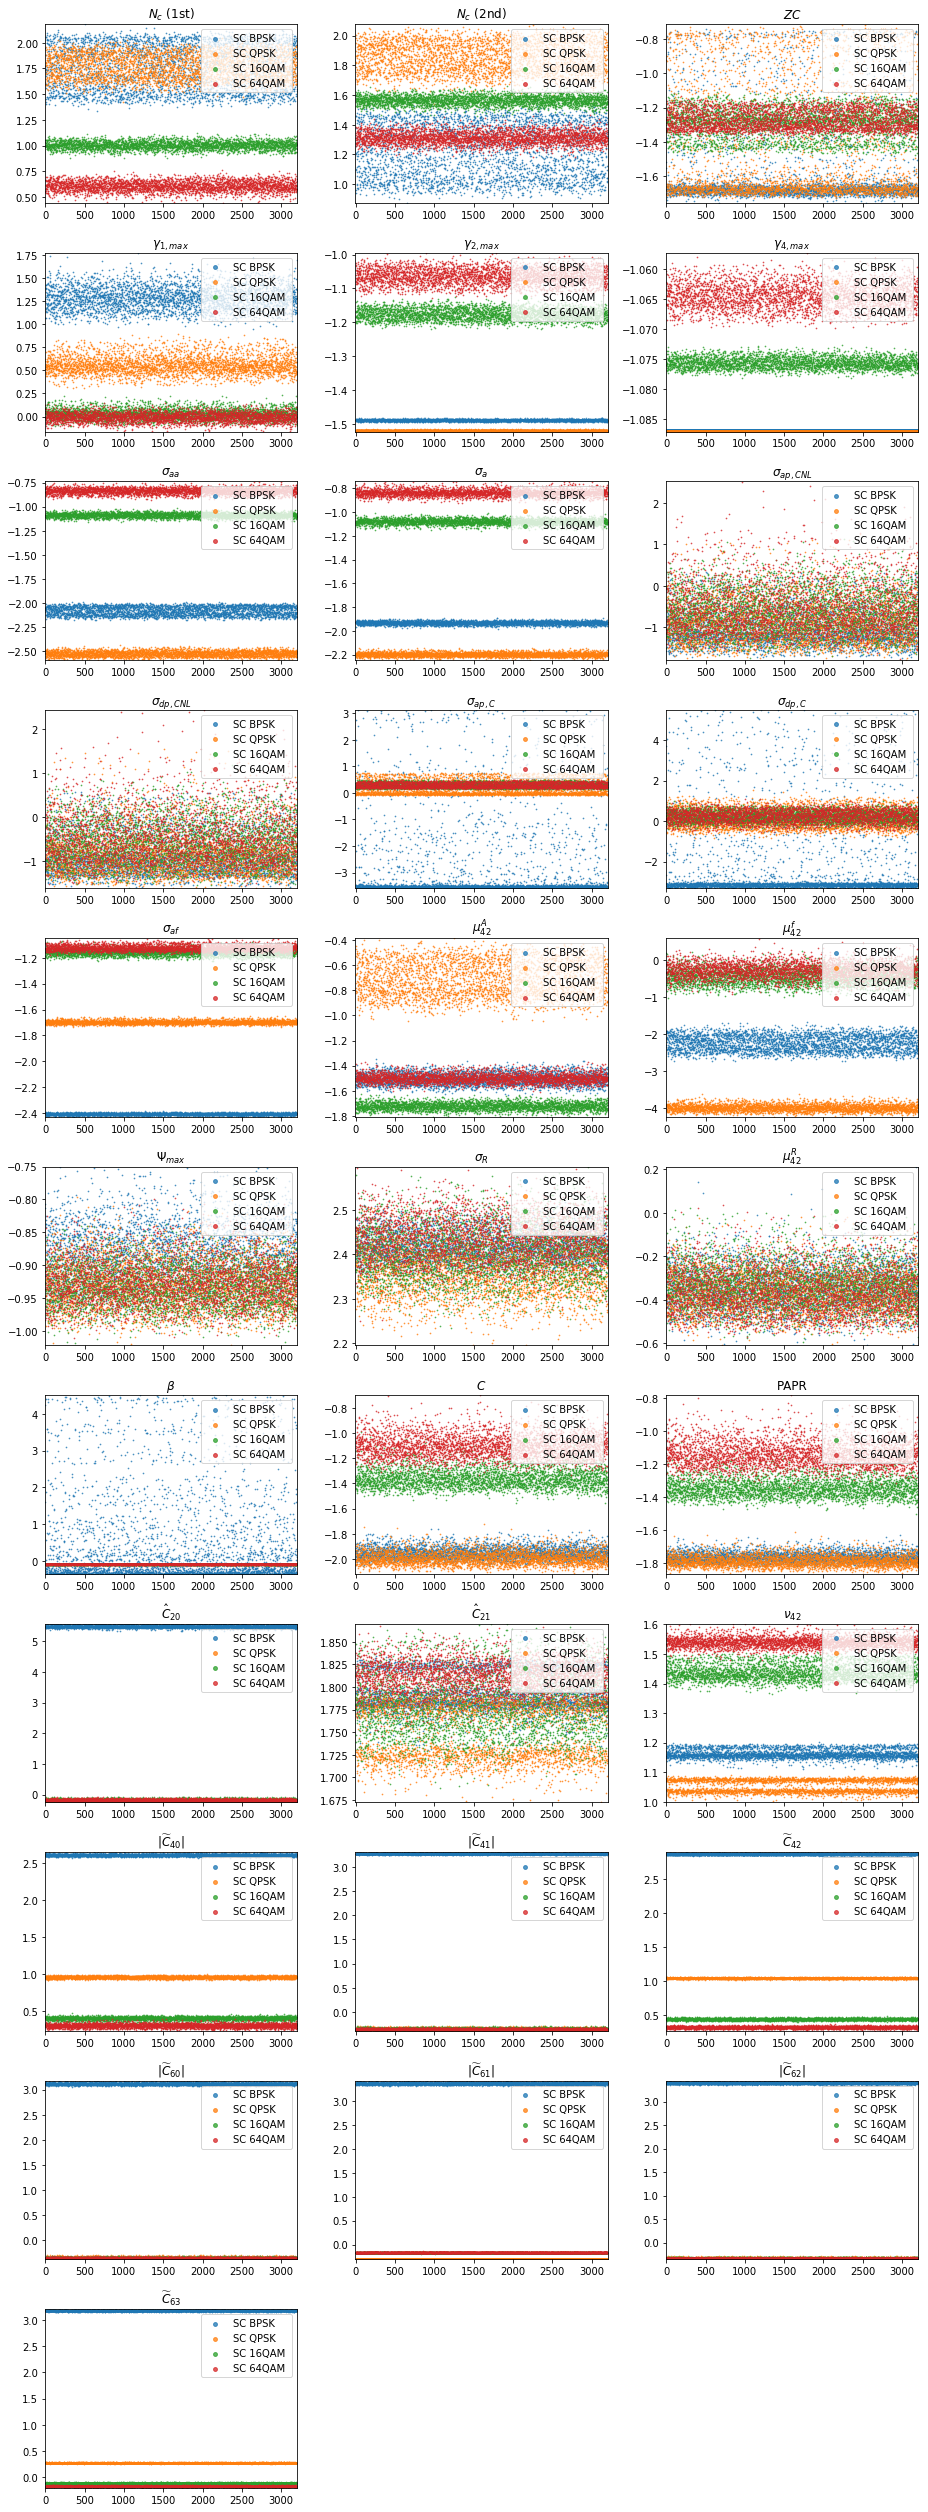

In [39]:
%matplotlib inline
fig, axs = get_plotgrid(len(features), 3)
for feature, ax in zip(features, axs):
    ax = show_features(ax, dfi, differentiators, legend_features, feature)
plt.tight_layout()
plt.show()

## Kernel density estimation

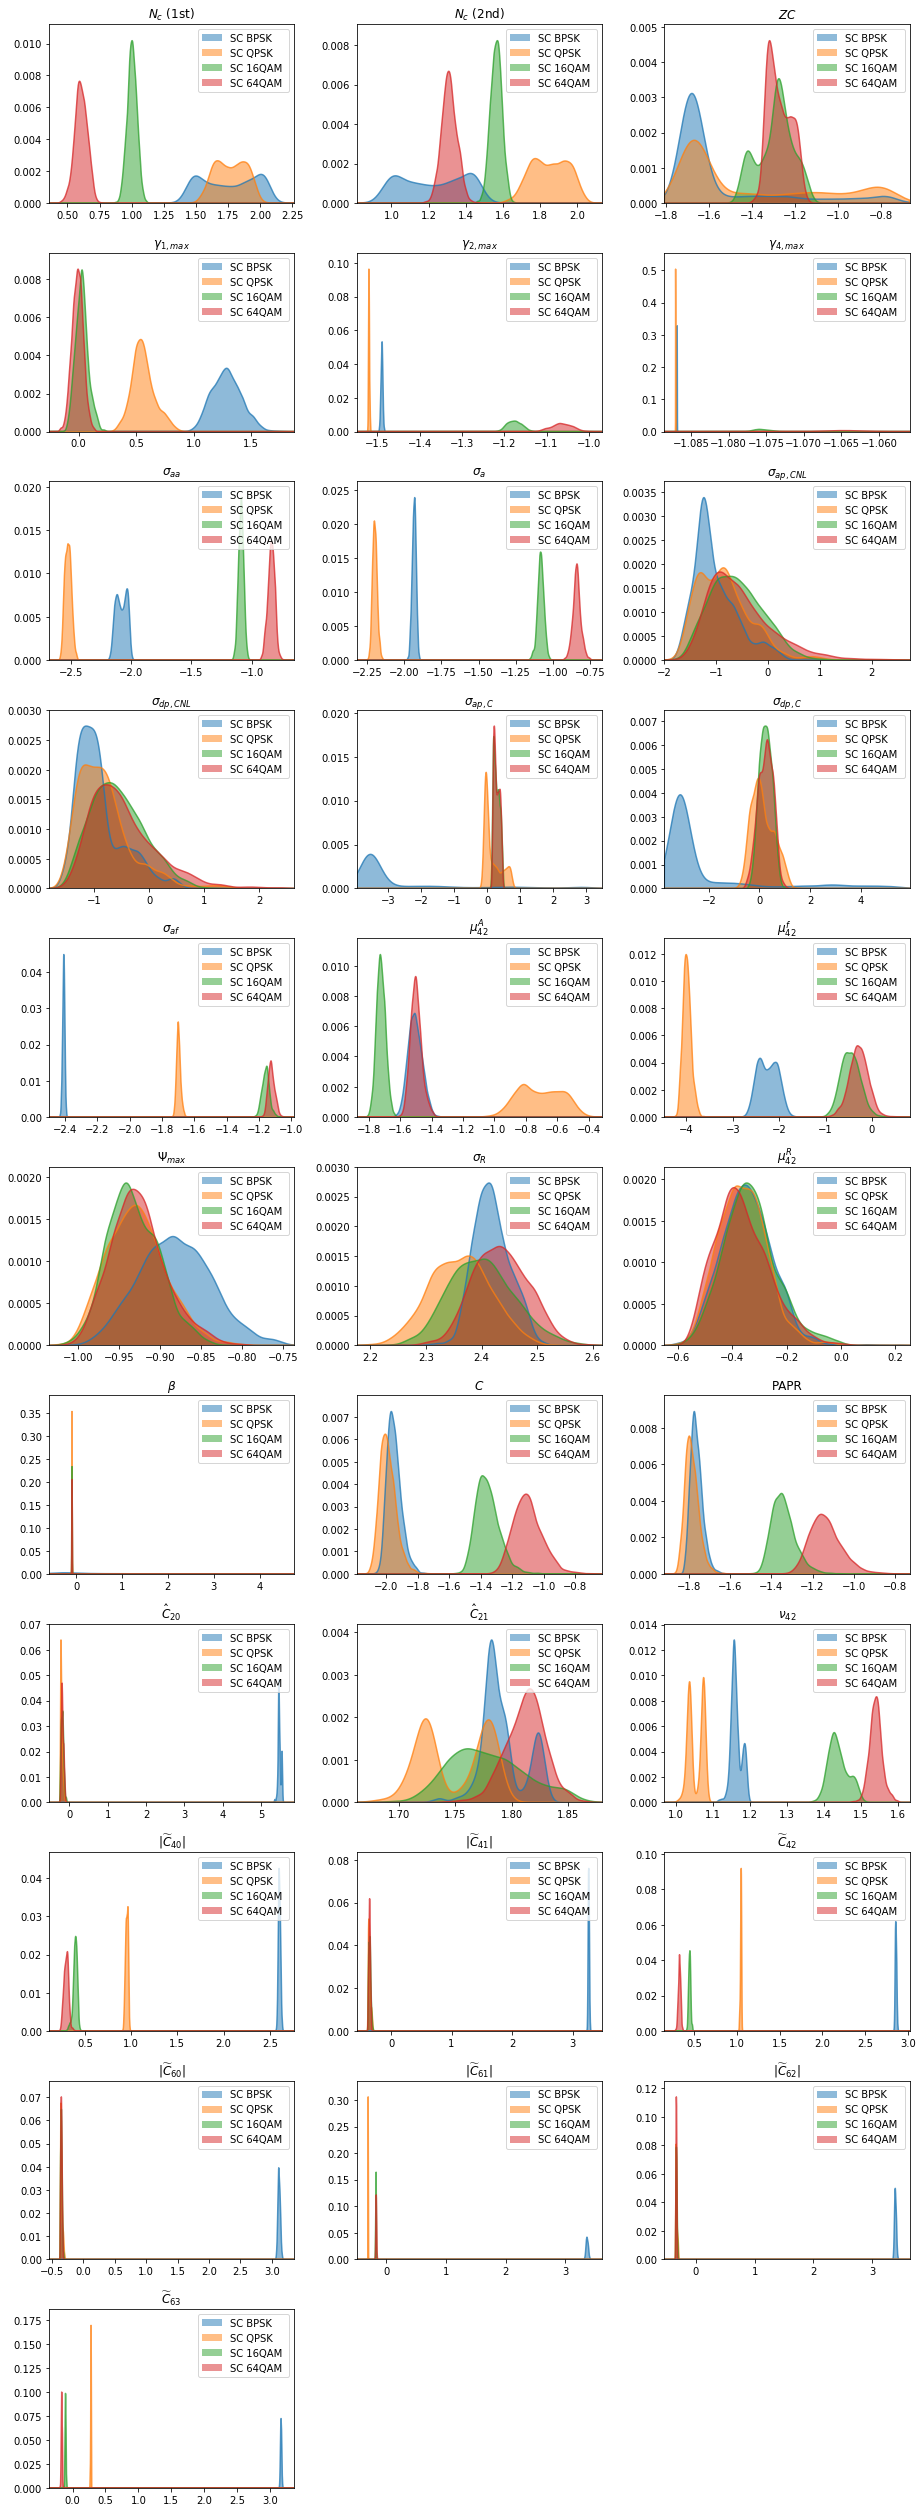

In [40]:
%matplotlib inline
fig, axs = get_plotgrid(len(features), 3)
for feature, ax in zip(features, axs):
    ax = show_kernel_density(ax, dfi, differentiators, legend_features, feature)
plt.tight_layout()
plt.show()

## Join plots

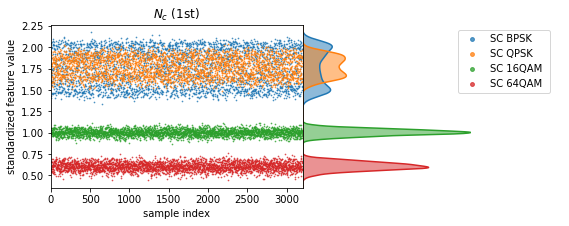

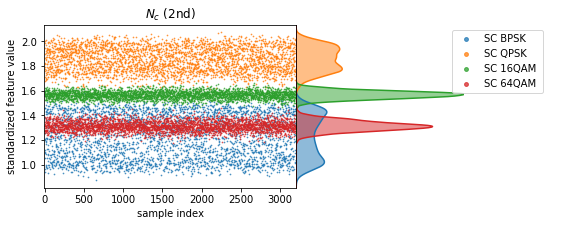

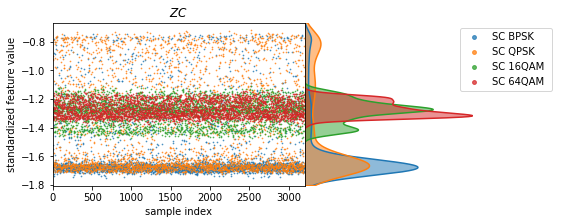

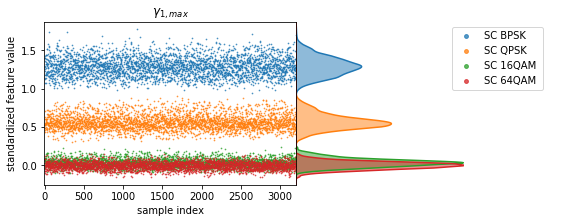

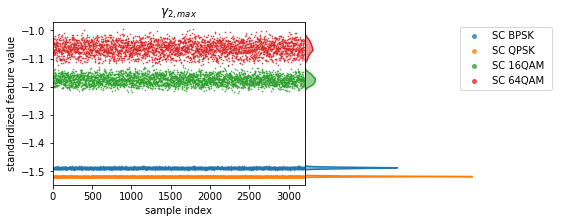

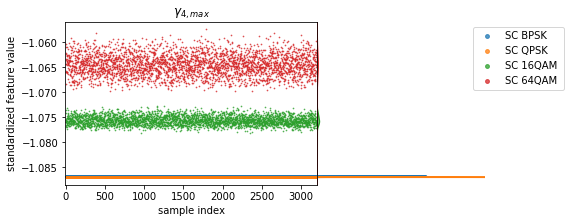

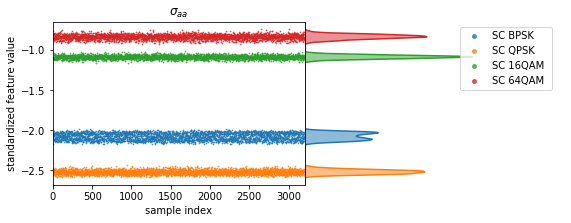

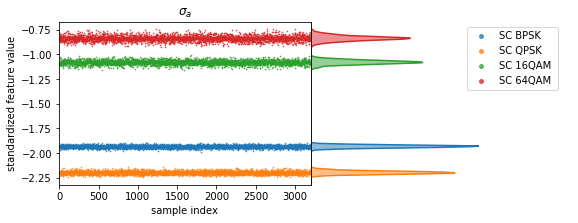

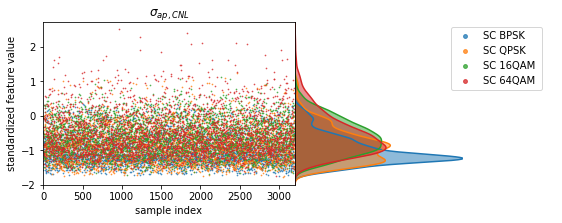

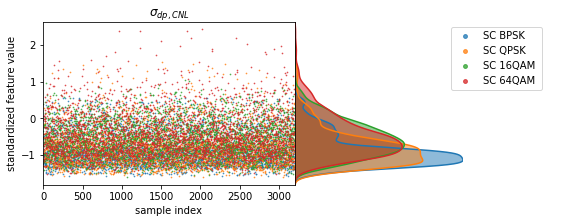

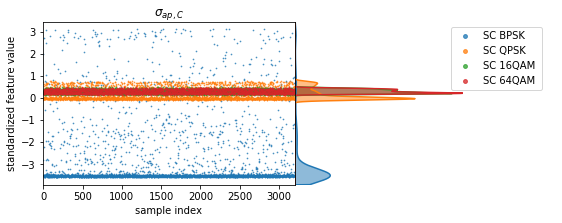

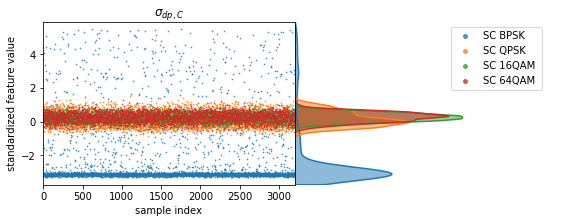

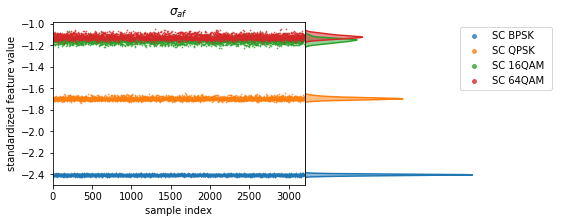

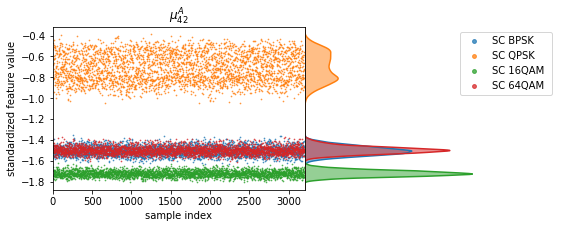

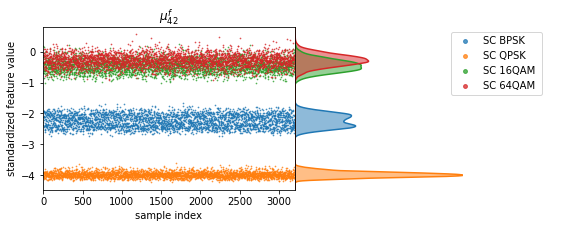

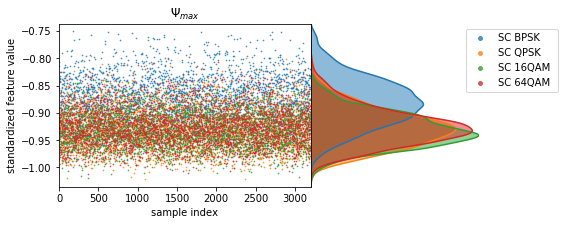

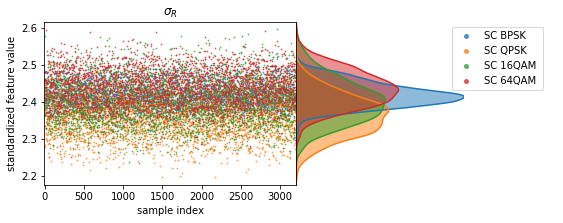

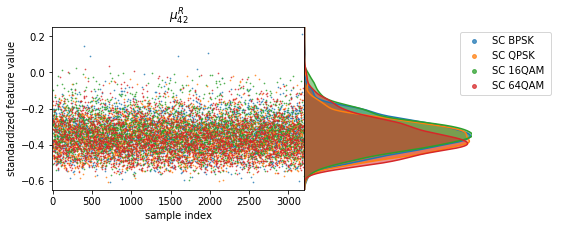

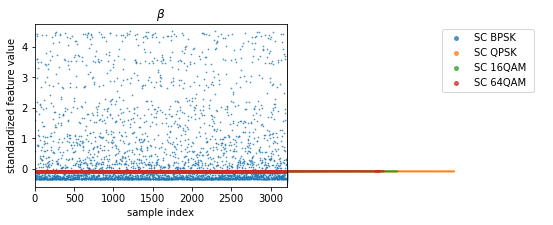

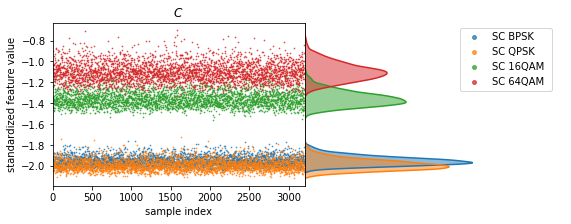

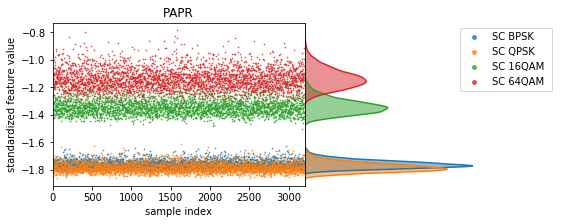

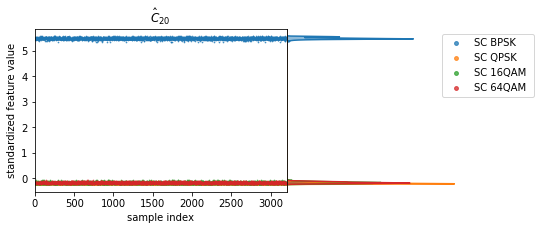

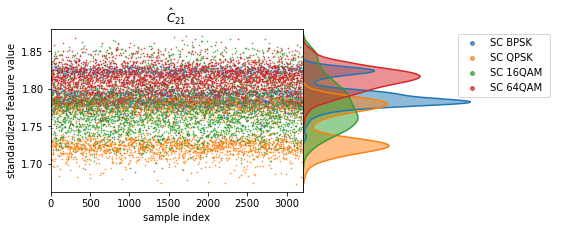

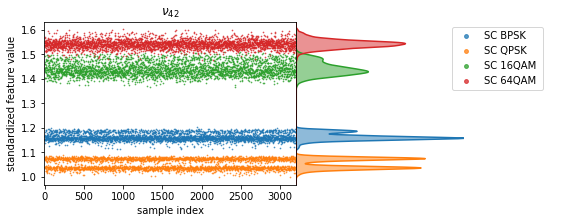

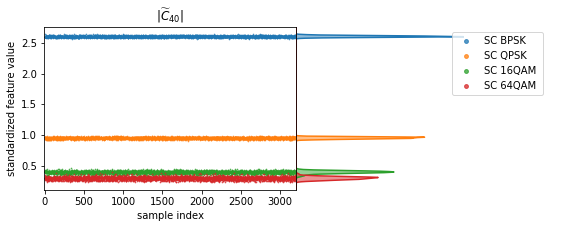

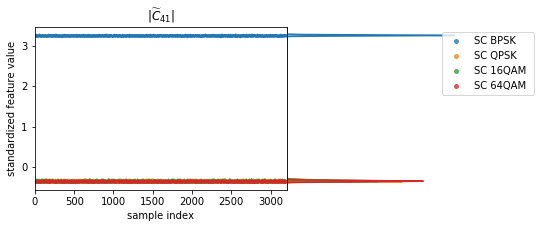

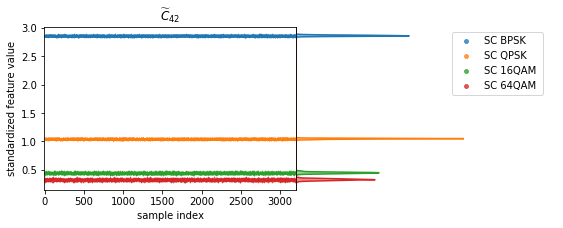

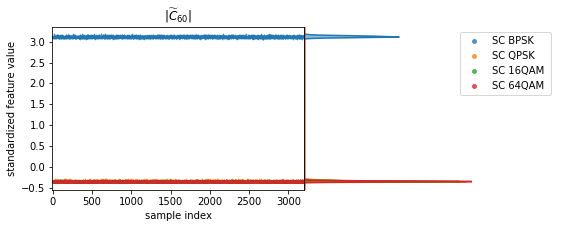

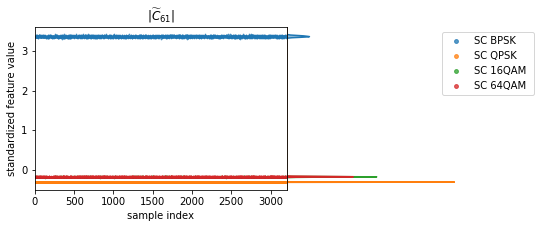

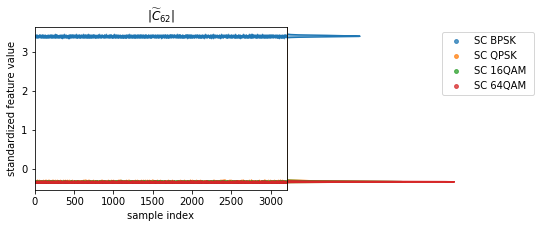

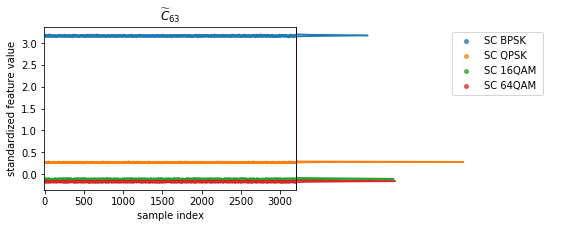

In [41]:
%matplotlib inline
for feature in features:
    join_plot(dfi, differentiators, legend_features, feature)

<hr>

# Show OFDM features in high SNR

In [ ]:
# config
features = all_features
differentiators=('mod', )
legend_features=('mod_type', 'mod')
dfi = df.copy()
dfi = dfi[dfi['y', 'mod_type'] == 'OFDM']
dfi = dfi[dfi['y', 'connection'] == 'ota']
dfi = dfi[dfi['y', 'snr_class'] == '20db']

## Kernel density estimation

In [ ]:
%matplotlib inline
fig, axs = get_plotgrid(len(features), 3)
for feature, ax in zip(features, axs):
    ax = show_kernel_density(ax, dfi, differentiators, legend_features, feature)
plt.tight_layout()
plt.show()

# Differentiation between SC and OFDM for high SNR

In [ ]:
# config
features = all_features
differentiators=('mod_type', 'mod')
legend_features=('mod_type', 'mod')
dfi = df.copy()
dfi = dfi[dfi['y', 'snr_class'] == '20db']
dfi = dfi[dfi['y', 'connection'] == 'cable']

dfi.loc[:,('y','mod_ofdm')] = dfi.loc[:,('y','mod')].copy()
dfi.loc[dfi['y', 'mod_type'] == 'OFDM', ('y','mod')] = 'all'
dfi.loc[dfi['y', 'mod_type'] == 'SC', ('y','mod_ofdm')] = 'none'
dfi = dfi.drop(dfi.loc[dfi['y', 'mod_type'] == 'OFDM'].iloc[3200:].index)

In [ ]:
%matplotlib inline
fig, axs = get_plotgrid(len(features), 3)
for feature, ax in zip(features, axs):
    ax = show_kernel_density(ax, dfi, differentiators, legend_features, feature)
plt.tight_layout()
plt.show()

<hr>
<hr>
<hr>
<hr>
<hr>
<hr>

# Feature selection by information criterion
from Peng et al. 2005

<hr>
Set of all features: $X = \{f_i\}_{i=1...N}$

## Max-Dependency

Find a feature set $S_m \subseteq X$ of features $\{f_i\}$ which jointly have the largeste dependency on the target class c.
$$\max D(S,c), D=I(\{f_i\}_{i=1...m}; c)$$

Solution: 
$$maximize \quad I(S_m; c) = \int\int p(S_m,c)\,\log\frac{p(S_m,c)}{p(S_m)p(c)}dS_mdc =
\int\dots\int p(x_1,\dots,x_m,c)\,\log\frac{p(x_1,\dots,x_m,c)}{p(x_1,\dots,x_m)p(c)}dx_1\dots dx_mdc $$

## Heuristic for Max-Dependency

Mutual information between classes and feature $f_i$:
$$I(f_i;c)=\sum_c\int p(f_i,c)log\frac{p(f_i,c)}{p(f_i)p(c)}df_i$$

At every step find the feature not yet in the set of selected features which maximizes the mutual information:
$$\max_{f_i\in X-S_{m-1}}\bigl[I(f_i,c)\bigr]$$

## Max-Relevance, Min-Redundancy (mRMR)

Max-Relevance:
$$\hat{D}(S,c) = \frac{1}{\lvert S \rvert}\sum_{f_i\in S} I(f_i; c)$$
Min-Redundancy:
$$\hat{R}(S) = \frac{1}{\lvert S \rvert^2}\sum_{f_i,f_j\in S} I(f_i; f_j)$$

$$\max\Phi(D,R), \Phi=D-R$$

At every step find the feature not yet in the set of selected features which maximizes $Phi$:
$$\max_{f_j \in X-S_{m-1}}\Bigl[ I(f_j; c) - \frac{1}{m-1} \sum_{f_i\in S_{m-1}} I(f_j; f_i) \Bigr]$$

# Features selected by Max-Dependency Heuristic: 
single carrier modulation, 20dB SNR, cable

In [ ]:
dfi = df[df['y', 'mod_type'] == 'SC']
dfi = dfi[dfi['y', 'snr_class'] == '20db']
feature_tuples = []

for feature in all_features:
    feature_tuples.append((mutual_information_class(dfi, feature, 'mod'), feature))

for score, feature in sorted(feature_tuples, key=lambda feature: feature[0], reverse=True):
    print("Mutual Information: %5.3f" % score)
    join_plot(dfi, features=[feature])

# Features ordered by maximum relevance minimum redundancy
single carrier modulation, 20dB SNR, cable

In [ ]:
dfi = df[df['y', 'mod_type'] == 'SC']
dfi = dfi[dfi['y', 'snr_class'] == '20db']

with ContextManager(streamhandler_level=logging.DEBUG, filehandler_path=home+"mRMR/") as contextmanager:
    
    mRMR(dfi, 20, class_label='mod', features=all_features)

In [ ]:
dfi = df[df['y', 'mod_type'] == 'SC']
dfi = dfi[dfi['y', 'snr_class'] == '20db']

with ContextManager(streamhandler_level=logging.DEBUG, filehandler_path=home+"mRMR/") as contextmanager:
    
    mRMR(dfi, 20, class_label='mod', features=all_features)

mRMR_features = S=['$\\widetilde{C}_{42}$', '$\\widetilde{C}_{63}$', '$|\\widetilde{C}_{61}|$', '$|\\widetilde{C}_{40}|$', '$\\mu^A_{42}$', '$\\gamma_{4,max}$', '$\x08eta$', '$\nu_{42}$', '$N_c$ (1st)', '$\\sigma_{af}$', '$C$', '$\\sigma_{a}$', '$\\mu^f_{42}$', '$|\\widetilde{C}_{62}|$', '$\\sigma_{aa}$', '$N_c$ (2nd)', '$\\sigma_{ap,C}$', '$\\gamma_{2,max}$', '$\\gamma_{1,max}$', 'PAPR']
for feature in mRMR_features:
    join_plot(dfi, features=[feature])